In [1]:
import yaw

In [2]:
ref_path = ('For_YAW/entire_reference_catalog')
rand_path = ('For_YAW/Random_catalog')
real_path = ('For_YAW/real_unknown_catalog')
fake_unkn_05_1_path = ('For_YAW/fake_unknown_catalog_05_1')

In [3]:
ref_path+'.csv'

'For_YAW/entire_reference_catalog.csv'

In [4]:
import pandas as pd

df_ref = pd.read_csv(ref_path+'.csv')
df_fake_05_1 = pd.read_csv(fake_unkn_05_1_path+'.csv')
df_rand = pd.read_csv(rand_path+'.csv')
df_real = pd.read_csv(real_path+'.csv')
 

In [5]:
df_ref = df_ref.rename(columns={'redshift': 'redshifts'})

In [6]:
import numpy as np
random_redshifts = np.random.uniform(0.5, 1, size=len(df_rand))

In [7]:
df_rand['redshifts'] = random_redshifts

In [8]:
from astropy.table import Table 

table_ref = Table.from_pandas(df_ref)
#table_05_1 = Table.from_pandas(df_05_1)
table_rand = Table.from_pandas(df_rand)
table_fake_05_1 = Table.from_pandas(df_fake_05_1)
table_real = Table.from_pandas(df_real)


table_ref.write(ref_path+'.fits', format='fits', overwrite=True)
#table_05_1.write('For_YAW/fake_unknown_catalog_05_1.fits', format='fits', overwrite=True)
table_rand.write(rand_path+'.fits', format='fits', overwrite=True)
table_real.write(real_path+'.fits', format='fits', overwrite=True)

In [9]:
cache_dir = "For_YAW/TEST"  # create as needed
reference_path = ref_path+'.fits'
ref_rand_path = rand_path+'.fits'
unknown_path = real_path+'.fits'
fake_05_1_path = fake_unkn_05_1_path+'.fits'

In [10]:
import os
import shutil
from yaw.utils import parallel

def delete_and_recreate_cache_directory(cache_dir):
    if parallel.on_root():  # if running with MPI, this is only executed on rank 0
        if os.path.exists(cache_dir):
            shutil.rmtree(cache_dir)
        os.mkdir(cache_dir)

In [11]:
delete_and_recreate_cache_directory(cache_dir)

In [12]:
patch_num = 1

cat_ref_rand = yaw.Catalog.from_file(
    cache_directory=f"{cache_dir}/ref_rand",
    path=ref_rand_path,
    ra_name="ra",
    dec_name="dec",
    #weight_name="weight",  # optional
    redshift_name="redshifts",  # required for reference
    # patch_centers=None,
    # patch_name=None,
    patch_num=patch_num,
    # degrees=True,
    # overwrite=False,
    progress=True,  # shows a progress bar, default: False
)

# extract the patch centers to use these for all following catalogs
patch_centers = cat_ref_rand.get_centers()

processed 1/1 (100%) t=0m02.99s
processed 1/1 (100%) t=0m01.54s


In [103]:
cat_reference = yaw.Catalog.from_file(
    cache_directory=f"{cache_dir}/reference",
    path=reference_path,
    ra_name="ra",
    dec_name="dec",
    #weight_name="weight",  # optional
    redshift_name="redshifts",  # required for reference
    patch_centers=patch_centers,  # use previously computed centers
    # patch_name=None,
    # patch_num=None,
    # degrees=True,
    # overwrite=False,
    progress=True,  # shows a progress bar, default: False
)

cat_unknown = yaw.Catalog.from_file(
    cache_directory=f"{cache_dir}/unknown",
    path=fake_05_1_path,
    ra_name="ra",
    dec_name="dec",
    #weight_name="weight",  # optional
    # we don't know the redshifts here, so we skip the argument
    patch_centers=patch_centers,  # use previously computed centers
    # patch_name=None,
    # patch_num=None,
    # degrees=True,
    # overwrite=False,
    progress=True,  # shows a progress bar, default: False
)

cat_unk_rand = None  # would be constructed same as cat_unknown

processed 1/1 (100%) t=0m02.75s
processed 1/1 (100%) t=0m01.46s
processed 1/1 (100%) t=0m02.71s
processed 1/1 (100%) t=0m01.46s


In [129]:
config = yaw.Configuration.create(
    rmin=500.0,  # can also be a list of lower scale limits
    rmax=1500.0, # can also be a list of upper scale limits
    # unit="kpc"  # defaults to angular diameter distance, but angles and
                  # comoving transverse distance are supported
    # rweight=None,     # if you want to weight pairs by scales
    # resolution=None,  # resolution of weights in no. of log-scale bins
    zmin=0.45,
    zmax=1.05,
    num_bins=50,
    # method="linear",
    # edges=None,  # provide your custom bin edges
)

In [130]:
cts_ss_list = yaw.autocorrelate(
    config,
    cat_reference,
    cat_ref_rand,
    progress=True,  # shows a progress bar, default: False
)


processed 1/1 (100%) t=0m01.61s
processed 1/1 (100%) t=0m01.45s
processed 1/1 (100%) t=0m01.80s
processed 1/1 (100%) t=0m01.50s
processed 1/1 (100%) t=0m01.48s


In [131]:

cts_sp_list = yaw.crosscorrelate(
    config,
    cat_reference,
    cat_unknown,
    ref_rand=cat_ref_rand,
    unk_rand=cat_unk_rand,
    progress=True,  # shows a progress bar, default: False
)

processed 1/1 (100%) t=0m01.47s
processed 1/1 (100%) t=0m01.48s
processed 1/1 (100%) t=0m01.49s
processed 1/1 (100%) t=0m01.63s
processed 1/1 (100%) t=0m01.57s


In [132]:
cts_ss = cts_ss_list[0]
#cts_ss.to_file("w_ss.hdf5")

cts_sp = cts_sp_list[0]
#cts_sp.to_file("w_sp.hdf5")
# restored = yaw.CorrFunc.from_file("w_sp.hdf5")

In [133]:
cts_sp_list[0]

CorrFunc(counts=dd|rd, auto=False, binning=50 bins @ (0.450...1.050], num_patches=1)

c:\Users\andre\anaconda3\envs\YAW\lib\site-packages\yaw\correlation\paircounts.py:564: RuntimeWarning: invalid value encountered in divide
  samples = _counts.samples / _weights.samples
c:\Users\andre\anaconda3\envs\YAW\lib\site-packages\yaw\correlation\paircounts.py:563: RuntimeWarning: invalid value encountered in divide
  data = _counts.data / _weights.data


<Axes: >

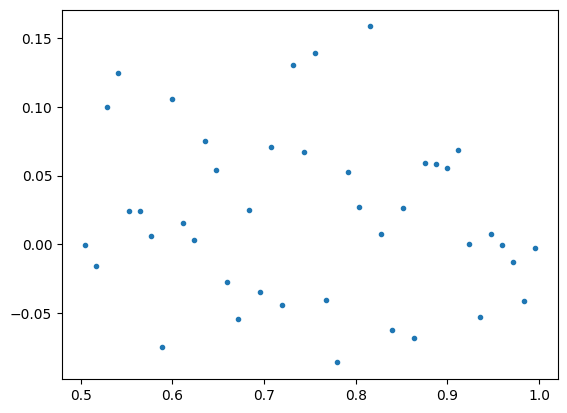

In [134]:
import matplotlib.pyplot as plt

w_sp = cts_sp.sample()  # creates a CorrFunc object
w_sp.plot()  # automatic plot

In [135]:
cts_sp.patches[3:6]  # subset with all pair counts involving patches 4 to 6
cts_sp.bins[:5]  # subset with all pair counts of the first 5 redshift bins

dd = cts_sp.dd  # access stored reference-unknown pair counts
hello = dd.get_array()  # array with shape (num_bins, num_patches, num_patches)


In [136]:
ncc = yaw.RedshiftData.from_corrfuncs(
    cross_corr=cts_sp,
    ref_corr=cts_ss,
    # unk_corr=None,
)

c:\Users\andre\anaconda3\envs\YAW\lib\site-packages\yaw\correlation\corrfunc.py:88: RuntimeWarning: divide by zero encountered in divide
  return ((dd - dr) + (rr - rd)) / rr
c:\Users\andre\anaconda3\envs\YAW\lib\site-packages\yaw\redshifts.py:290: RuntimeWarning: invalid value encountered in sqrt
  nz_data = w_sp_data / np.sqrt(dz2_data * w_ss_data * w_pp_data)


In [137]:
ncc.data  # length num_bins
ncc.error  # length num_bins
ncc.samples  # shape (num_samples=num_patches, num_bins)
ncc.covariance  # shape (num_bins, num_bins)

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(50, 50))

In [138]:
# Create a folder to store csv file
output_folder_csvfile = 'C:/Users/andre/MasterCode/Code/YAW_results/TEST'
os.makedirs(output_folder_csvfile, exist_ok=True)  # Creates the folder if it doesn't exist

file_name = os.path.join(output_folder_csvfile, 'TEST')
ncc.to_files(file_name)
    # data/error         ->  nz_estimate.dat
    # jackknife samples  ->  nz_estimate.smp
    # covariance         ->  nz_estimate.cov
# restored = yaw.RedshiftData.from_files("nz_estimate")

In [139]:
# ncc.plot(
#     # label=None,
#     # ax=None,  # plot to specific matplotlib axis
#     # ...
# )



In [148]:
cts_sp.bins[:]

CorrFunc(counts=dd|rd, auto=False, binning=50 bins @ (0.450...1.050], num_patches=1)

In [149]:
print(ncc.normalised().data)
print(ncc.normalised().error)

[            nan             nan             nan             nan
             nan -1.55926588e+00             nan  3.72497483e+01
             nan             nan             nan -8.83464679e+00
             nan             nan  4.23028244e-01             nan
  5.62955699e+00             nan             nan             nan
             nan             nan -4.63832331e+00  2.49644571e+01
             nan             nan -4.90393769e+00             nan
  4.34553409e+00             nan  1.89068074e+01  5.73628987e-01
 -1.06434873e+01  3.09597186e+00             nan  4.95517904e+00
  9.48086462e+00  6.50237456e+00             nan  2.20945448e-02
             nan             nan             nan -1.99065063e+00
             nan -2.45600776e-01             nan             nan
             nan             nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan

Text(0, 0.5, 'P(z)')

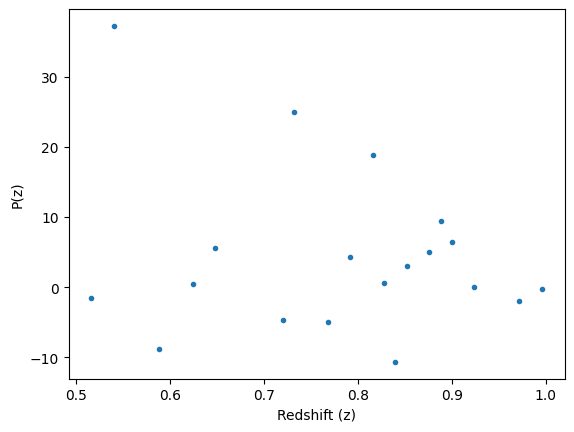

In [141]:
# or even with estimated normalisation
ncc.normalised().plot()
plt.xlabel('Redshift (z)')
plt.ylabel('P(z)')